<a href="https://colab.research.google.com/github/SYBIOTE/CMEPCMGN/blob/main/comouflage_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#repositories

In [108]:
!git clone https://github.com/experiencor/deep-viz-keras
!git clone https://github.com/SYBIOTE/camogen
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'deep-viz-keras' already exists and is not an empty directory.
fatal: destination path 'camogen' already exists and is not an empty directory.
fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


# RCNN

In [109]:
pip install Mask_RCNN/

Processing ./Mask_RCNN
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp37-none-any.whl size=56924 sha256=7d0a95c88a529a12a1e90f3b44ec58fc0cc604cfb70908ec8dbf837397a969f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-on621t8p/wheels/78/da/b4/63931b0b9847ef98ac88d2b032817246adcf667c5da577133f
Successfully built mask-rcnn
  Found existing installation: mask-rcnn 2.1
    Uninstalling mask-rcnn-2.1:
      Successfully uninstalled mask-rcnn-2.1


In [110]:
%tensorflow_version 1.x

In [111]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [112]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [113]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [114]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [129]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread("/content/camogen/car.jpeg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

Processing 1 images
image                    shape: (168, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


# mask and filtering

Text(0.5, 1.0, 'original')

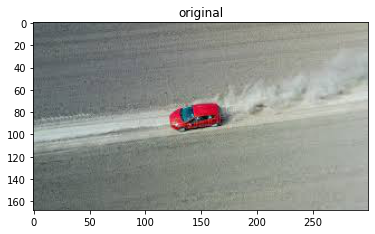

In [130]:
plt.imshow(image)
plt.title("original")

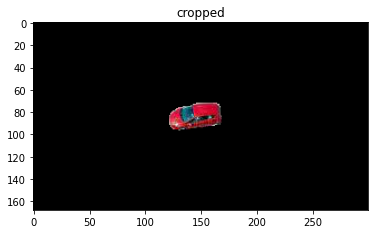

In [131]:
i = 0
mask = r["masks"]
cropped = image.copy()
for j in range(cropped.shape[2]):

    cropped[:,:,j] = cropped[:,:,j] * mask[:,:,i]


plt.imshow(cropped)
plt.title("cropped")
i+=1

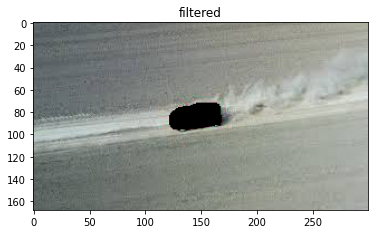

In [133]:
i = 0
mask = r["masks"]
filtered = image.copy()
for j in range(filtered.shape[2]):

    filtered[:,:,j] = filtered[:,:,j] - cropped[:,:,j]


plt.imshow(filtered)
plt.title("filtered")
i+=1

# Color Extraction

## load image

In [134]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering

In [135]:
dominant_color = 5
hexadecimal_color_minibatch_kmean = []
hexadecimal_color_kmean = []
score_minibatch = []
score = []

(168, 300, 3)


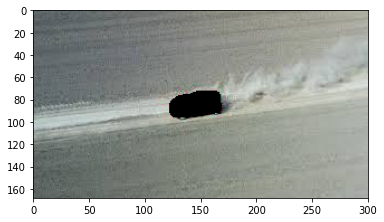

In [136]:
img = filtered

x_end , y_end = img.shape[0:2]
print(img.shape)

plt.imshow(img ,extent=[0,y_end,x_end,0])

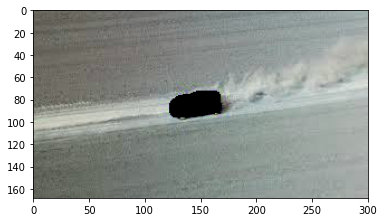

In [137]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img , extent=[0,y_end,x_end,0])

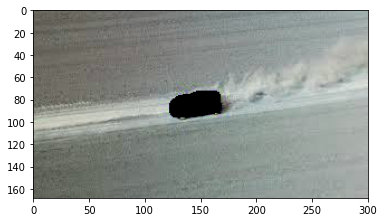

In [138]:
plt.imshow(img ,extent=[0,y_end,x_end,0])

In [139]:
original_pixel = img.shape
print(original_pixel)

(168, 300, 3)


In [140]:
pixel = img.reshape((x_end*y_end , 3))
print(pixel.shape)

(50400, 3)


## K-means minibatch

In [141]:
%%time
km = MiniBatchKMeans( n_clusters = dominant_color)
km.fit(pixel)

CPU times: user 530 ms, sys: 6 ms, total: 536 ms
Wall time: 541 ms


[[110 112 105]
 [158 167 163]
 [113 118 114]
 [133 141 138]
 [187 193 188]]
['#6e7069', '#9ea7a3', '#717672', '#858d8a', '#bbc1bc']


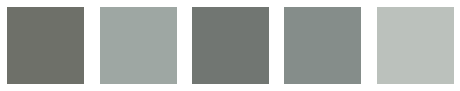

In [179]:
minibatch_centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
minibatch_centers = np.array(minibatch_centers , dtype='uint8')
avg = [0,0,0]
for x in minibatch_centers:
    if not (x[0]==x[1]==x[2]==0):
      avg += (x/len(minibatch_centers)-1)
minibatch_centers[np.where(minibatch_centers == [0,0,0])] = avg

print(minibatch_centers)
hexadecimal_color_minibatch_kmean.clear()
for array in minibatch_centers:
  hexadecimal_color_minibatch_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )

print(hexadecimal_color_minibatch_kmean)
#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in minibatch_centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)

plt.show()



In [175]:
%%time
score_minibatch.clear()
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score_minibatch.append(sum/len(km.labels_))

print(score_minibatch)
print(hexadecimal_color_minibatch_kmean)


[0.3026587301587302, 0.2748809523809524, 0.019067460317460316, 0.2833730158730159, 0.12001984126984128]
['#6e7069', '#9ea7a3', '#717672', '#858d8a', '#bbc1bc']
CPU times: user 450 ms, sys: 979 µs, total: 451 ms
Wall time: 453 ms


## SpectralClustering

In [ ]:
# %%time
km = SpectralClustering(assign_labels='discretize', n_clusters = dominant_color)
km.fit(pixel)

In [ ]:
from math import sqrt

# cluster points
points = pixel

# measure distance between two points
def distance_2point(x1, y1, x2, y2):
	return sqrt((x2-x1)**2 + (y2-y1)**2)


# estimate volume of the cluster
def volume_estimation(cluster, center):
	num_of_points = len(cluster)
	distance = []
	for i in range(num_of_points):
		distance.append(distance_2point(center[0], center[1], cluster[i][0], cluster[i][1]))

	return sum(distance)/num_of_points


# defining of new cluster center
def new_cluster_centers(cluster):
	s = list(map(sum, zip(*cluster)))
	length = len(cluster)
	return (s[0]/length, s[1]/length)


# measure distances between each two pairs of cluster centers
def center_distance(centers):
	D_ij = {}
	# offset coeficient
	k = 0
	for i in range(len(centers)):
		for j in range(k, len(centers)):
			if i == j:
				pass
			else:
				D_ij[(i,j)] = distance_2point(centers[i][0], centers[i][1], centers[j][0], centers[j][1])
		k +=1
	return D_ij


# standart deviation vector for cluster
def standart_deviation(values, center):
	n = len(values) 
	x_coord = []
	y_coord = []
	for i in range(n):
		x_coord.append((values[i][0]-center[0])**2)
		y_coord.append((values[i][1]-center[1])**2)

	x = sqrt(sum(x_coord)/n)
	y = sqrt(sum(y_coord)/n)

	return (x,y)


def cluster_points_distribution(centers, points):
	centers_len = len(centers)
	points_len = len(points)
	distances = []
	distance = []

	# define array for clusters
	clusters = [[] for i in range(centers_len)]

	# iteration throught all points
	for i in range(points_len):
		# iteration throught all centers
		for j in range(centers_len):
			distance.append(distance_2point(centers[j][0], centers[j][1], points[i][0], points[i][1]))
		distances.append(distance)
		distance = []

	# distribution
	for i in range(points_len):
		ind = distances[i].index(min(distances[i]))
		clusters[ind].append(points[i])

	return clusters


def cluster_division(cluster, center, dev_vector):
	#divide only center of clusters

	# coeficient
	k = 0.5

	max_deviation = max(dev_vector)
	index = dev_vector.index(max(dev_vector))
	g = k*max_deviation

	# defining new centers
	center1 = list(center)
	center2 = list(center)
	center1[index] += g
	center2[index] -= g

	cluster1 = []
	cluster2 = []

	return tuple(center1), tuple(center2)


def cluster_union(cluster1, cluster2, center1, center2):
	x1 = center1[0]
	x2 = center2[0]
	y1 = center1[1]
	y2 = center2[1]
	n1 = len(cluster1)
	n2 = len(cluster2)

	x = (n1*x1 + n2*x2)/(n1+n2)
	y = (n1*y1 + n2*y2)/(n1+n2)
	center = (x,y)
	cluster = cluster1 + cluster2

	return center, cluster


def clusterize():

	# initial values
	K = 3 # max cluster number
	THETA_N = 1 # for cluster elimination
	THETA_S = 1 # for cluster division
	THETA_C = 3 # for cluster union
	L = 3 # 
	I = 4 # max number of iterations
	N_c = 1 # number of primary cluster centers

	distance = [] # distances array
	centers = [] # clusters centers
	clusters = [] # array for clusters points
	iteration = 1 # number of current iteration
	
	centers.append(points[0]) # first cluster center


	while iteration <= I:
		#print ("Iteration ", iteration)
		# step 2

		"""
		if there are one cluster center - all points goes to first cluster
		otherwise we distribute points between clusters
		"""
		if len(centers) <= 1:
			clusters.append(points)
		else:
			clusters = cluster_points_distribution(centers, points)
		
		# step 3
		# eliminating small clusters (unfinished!!!!!!)
		"""
		for i in range(len(clusters)):
			if len(clusters[i]) <= THETA_N:
				print(clusters[i][i])
				item = clusters[i][i]
				points.remove(item)
				#del clusters[i]
				break
			else:
				print("else")
			break	
			"""
			
		
		# step 4
		# erasing existing centers and defining a new ones
		centers = []
		for i in range(len(clusters)):
			centers.append(new_cluster_centers(clusters[i]))

		# step 5 - estimating volumes of all clusters
		# array for clusters volume
		D_vol = []
		for i in range(len(centers)):
			D_vol.append(volume_estimation(clusters[i], centers[i]))

		# step 6
		if len(clusters) <= 1:
			D = 0
		else:		
			cluster_length = []
			vol_sum = []
			for i in range(len(centers)):
				cluster_length.append(len(clusters[i]))
				vol_sum.append(cluster_length[i]*D_vol[i])

			D = sum(vol_sum)/len(points)


		# step 7
		if iteration >= I:
			THETA_C = 0

		elif (N_c >= 2*K) or (iteration % 2 == 0):
			pass

		else:
			# step 8
			# vectors of all clusters standart deviation 
			vectors = []
			for i in range(len(centers)):
				vectors.append(standart_deviation(clusters[i], centers[i]))

			# step 9
			max_s = []
			for v in vectors:
				max_s.append(max(v[0], v[1]))

			#step 10 (cluster division)
			for i in range(len(max_s)):
				length = len(clusters[i])
				coef = 2*(THETA_N+1)

				if (max_s[i] > THETA_S) and ((D_vol[i]>D and length>coef) or N_c<float(K)/2):
					center1, center2 = cluster_division(clusters[i], centers[i], vectors[i])
					del centers[i]
					centers.append(center1)
					centers.append(center2)
					N_c += 1

				else:
					pass
		

		#for i in clusters:
		#	print(i)

		# step 11
		D_ij = center_distance(centers)
		rang = {}
		for coord in D_ij:
			if D_ij[coord] < THETA_C:
				rang[coord] = (D_ij[coord])
			else:
				pass

		"""
		# step 13 (cluster union)
		for key in rang.keys():
			cluster_union(clusters[key], clusters[key.next()], centers[key], centers[key.next()])
			N_c -= 1
			"""

		iteration += 1


	return clusters

if __name__ == '__main__':
	# if file called as a script
	cl = clusterize()
	for i in cl:
		print("Cl", i)



## K-means

In [ ]:
%%time
km = KMeans( n_clusters = dominant_color)
km.fit(pixel)

CPU times: user 871 ms, sys: 733 ms, total: 1.6 s
Wall time: 868 ms


### forward

In [ ]:
centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
centers = np.array(centers , dtype='uint8')
print("After : ",centers)

In [ ]:
for array in centers:
  hexadecimal_color_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )


In [ ]:
hexadecimal_color_kmean

In [ ]:
hexadecimal_color

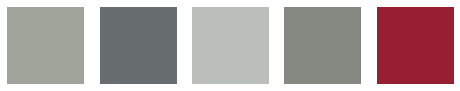

In [ ]:

#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)
plt.show()



In [ ]:
%%time
score = []
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score.append(sum/len(km.labels_))

print(score)
print(hexadecimal_color)

[0.300734126984127, 0.2746825396825397, 0.1394047619047619, 0.27226190476190476, 0.012916666666666667]


NameError: ignored

In [ ]:
# segmenting the original image
new_pixel = np.zeros((x_end*y_end , 3))

color 

[array([160, 164, 154], dtype=uint8),
 array([103, 110, 109], dtype=uint8),
 array([187, 191, 185], dtype=uint8),
 array([133, 137, 130], dtype=uint8),
 array([151,  31,  50], dtype=uint8)]

In [ ]:
km.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
for i in range(new_pixel.shape[0]):
  new_pixel[i] = color[km.labels_[i]]

new_pixel = new_pixel.reshape(original_pixel)

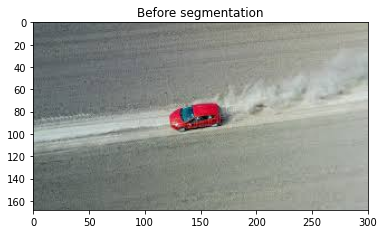

In [ ]:
plt.imshow(img ,extent=[0,y_end,x_end,0])
plt.title("Before segmentation")
plt.show()

In [ ]:
new_pixel /= 255

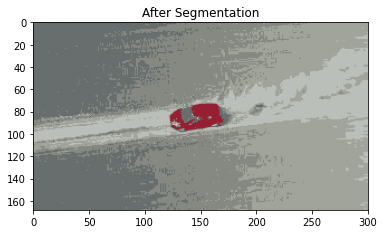

In [ ]:
plt.imshow(new_pixel , extent=[0,y_end,x_end,0])
plt.title("After Segmentation")
plt.show()

In [ ]:
new_pixel

array([[[0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        ...,
        [0.62745098, 0.64313725, 0.60392157],
        [0.62745098, 0.64313725, 0.60392157],
        [0.73333333, 0.74901961, 0.7254902 ]],

       [[0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        ...,
        [0.62745098, 0.64313725, 0.60392157],
        [0.62745098, 0.64313725, 0.60392157],
        [0.62745098, 0.64313725, 0.60392157]],

       [[0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        ...,
        [0.62745098, 0.64313725, 0.60392157],
        [0.62745098, 0.64313725, 0.60392157],
        [0.62745098, 0.64313725, 0.60392157]],

       ...,

       [[0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0.43137255, 0.42745098],
        [0.40392157, 0

In [ ]:
from PIL import Image
im = Image.fromarray(new_pixel)
im.save("segmented.jpg")


TypeError: ignored

In [ ]:
import scipy.misc
scipy.misc.imsave('outfile.jpg', new_pixel)

#Camogen

In [176]:
pip install /content/camogen

Processing ./camogen
  Created wheel for Camogen: filename=Camogen-0.1-cp37-none-any.whl size=9733 sha256=2b77f9dd59df44f558c1b54b3aee995cffc38930d4f975834db0988485625679
  Stored in directory: /tmp/pip-ephem-wheel-cache-vj6b37n9/wheels/27/b0/23/041bdf4776dc0ce4676d1d09369e681caf2b0c9519e3d4e40e
Successfully built Camogen
  Found existing installation: Camogen 0.1
    Uninstalling Camogen-0.1:
      Successfully uninstalled Camogen-0.1


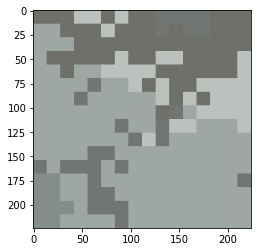

In [180]:
import camogen
import matplotlib.pyplot as plt
from camogen.generate import generate

parameters = {'width': 224, 'height': 224, 'polygon_size': 100, 'color_bleed': 5,'max_depth':8,
              'colors': hexadecimal_color_minibatch_kmean,
              'spots': {'amount': 20000/4, 'radius': {'min': 10/4, 'max': 40/4}, 'sampling_variation': 10},
              'pixelize': {'percentage': 1, 'sampling_variation': 20, 'density': {'x': 15, 'y': 15}}}
image = generate(parameters)
plt.imshow(image)
image.save('/content/camogen/images/genrated.png')

#pattern overlappping

# saliency map



In [ ]:
cd deep-viz-keras/

/content/deep-viz-keras


In [ ]:
import PIL as PIL
from PIL import Image
from PIL import *
import numpy as np
from matplotlib import pylab as plt
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)
    
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

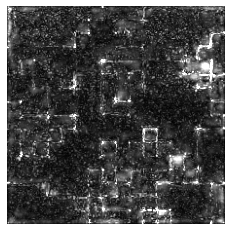

In [ ]:
from saliency import GradientSaliency
#from utils import *
from keras.applications.vgg16 import VGG16
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution() 
# Load the pretrained VGG16 model and make the guided backprop operator
model = VGG16(weights='imagenet')
model.compile(loss='categorical_crossentropy', optimizer='adam')

vanilla = GradientSaliency(model)
 
# Load the image and compute the guided gradient
image = load_image('/content/camogen/images/genrated.png')
mask = vanilla.get_smoothed_mask(image)            # compute the gradients
show_image(mask)                                  # display the grayscaled mask